## Імпортування бібліотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

## Завантаження даних

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=[0], index_col=[0])
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Візуалізація

<AxesSubplot: title={'center': 'Monthly Airline Passengers'}, xlabel='Month'>

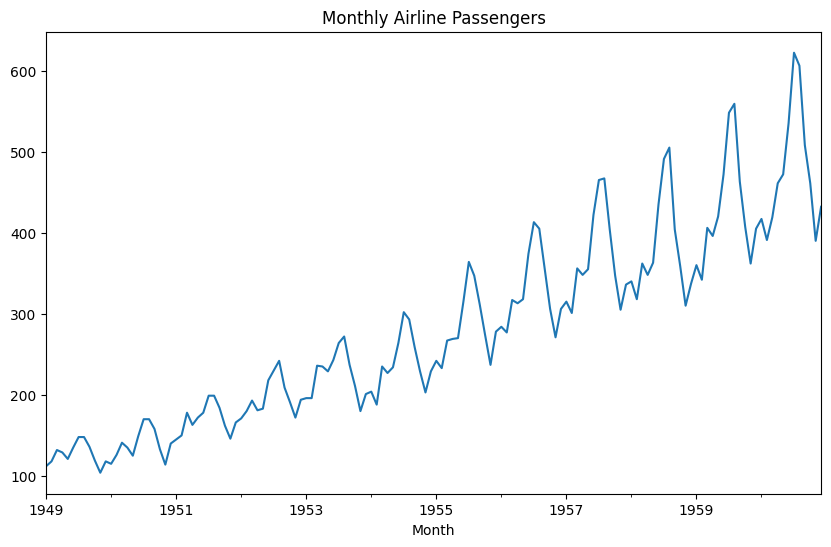

In [4]:
df['Passengers'].plot(title='Monthly Airline Passengers', figsize=(10, 6))

## Ознаки

1. Ми прогнозуємо значення на наступний рік (12 точок даних).
2. Мінімальний лаг, який доцільно використати, один рік (12 місяців).
3. У даних помітна сезонність, тож місяць може стати корисною ознакою.
4. Також є лінійний тренд, тому варто врахувати рік як додаткову ознаку.

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['lag_12'] = df['Passengers'].shift(12)

# features and target
features = ['year', 'month', 'lag_12']
target = 'Passengers'

# drop rows with NaN values
df.dropna(inplace=True)

In [8]:
df.head(5)

,Passengers,year,month,lag_12
Month,,,,
1950-01-01,115,1950,1,112.0
1950-02-01,126,1950,2,118.0
1950-03-01,141,1950,3,132.0
1950-04-01,135,1950,4,129.0
1950-05-01,125,1950,5,121.0


## Лінійна регресія з крос-валідацією

1. Натренуйте модель лінійною регресії, оцінивши середнє значення метрики r2
2. Розмір тестової вибірки дорівнює 12
3. Кількість повторень при крос-валідації - 3

In [60]:
t_series = TimeSeriesSplit(n_splits=3, test_size=12)
X_train, y_train = df[features][:-12], df[target][:-12]
X_test, y_test = df[features][-12:], df[target][-12:]
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
predictions = model.predict(X_test)

In [66]:
mean_squared_error(predictions, y_test)

322.06925166595676

In [65]:
cross_val = cross_val_score(model, df[features], df[target], cv=t_series, scoring='neg_mean_squared_error')
cross_val

array([-1522.50729938,  -429.7694155 ,  -322.06925167])

In [67]:
cross_val.mean()

-758.1153221829136

## XGBoost та GridSearch


In [68]:
train, test = df.iloc[:-12], df.iloc[-12:]
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = XGBRegressor()
ts_split = TimeSeriesSplit(n_splits=3, test_size=12)
param_grid = {'n_estimators': [20, 50, 100, 200],
              'max_depth':[3, 5, 7, 10],
              'learning_rate':[0.01, 0.05, 0.1, 0.2]
}
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=ts_split, refit=True)
grid_search.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [20, 50, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl... test_size=12)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [69]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}

In [74]:
XGBoost_preds = grid_search.best_estimator_.predict(X_test)

In [75]:
mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test))

1283.740234375

## Візуалізація

In [15]:
# TODO: Побудуйте графік:
# Зробіть прогноз на тестову вибірку (останні 12 місяців) для обох моделей
# Побудуйте графік з:
# - Фактичні значення y_test
# - Прогнози лінійної регресії
# - Прогнози XGBoost
#  Порівняйте якість моделей

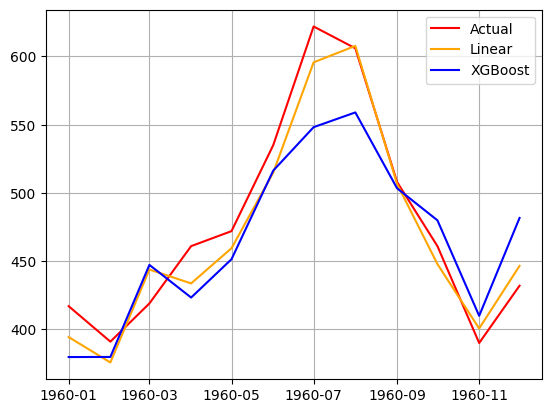

In [76]:
# plt.plot(y_train.index, y_train, label='Train', color='green')
plt.plot(y_test.index, y_test, label='Actual', color='red')
plt.plot(y_test.index, predictions, label='Linear', color='orange')
plt.plot(y_test.index, XGBoost_preds, label='XGBoost', color='blue')
plt.legend()
plt.grid()
plt.show()

### Висновки
Для данного датасету як за mean_squared_error так і на графіку видно, що Лінійна регересія робить кращий прогноз